# The Histogram That Started It All

L2 norm of every token embedding in Qwen 3 4B's unembedding matrix. 

A nice Gaussian-ish distribution... with a spike on the trailing edge.

---

In [1]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tensors = load_file("../tensors/qwen3_4b_instruct_2507.safetensors")
W = tensors["W"]  # [151936, 2560] bf16
black_hole_mask = tensors["black_hole_mask"]  # [151936] bool

print(f"Total tokens: {W.shape[0]:,}")
print(f"Black hole tokens: {black_hole_mask.sum().item():,}")

Total tokens: 151,936
Black hole tokens: 2,100


In [3]:
# Compute L2 norm for every token
norms = torch.norm(W.float(), dim=1)  # [151936]

norms_dead = norms[black_hole_mask]
norms_live = norms[~black_hole_mask]

print(f"Norm statistics:")
print(f"  All tokens:  min={norms.min():.4f}, max={norms.max():.4f}, mean={norms.mean():.4f}, std={norms.std():.4f}")
print(f"  Dead tokens: min={norms_dead.min():.4f}, max={norms_dead.max():.4f}, mean={norms_dead.mean():.4f}, std={norms_dead.std():.4f}")
print(f"  Live tokens: min={norms_live.min():.4f}, max={norms_live.max():.4f}, mean={norms_live.mean():.4f}, std={norms_live.std():.4f}")

Norm statistics:
  All tokens:  min=0.3595, max=1.6050, mean=1.0873, std=0.1681
  Dead tokens: min=0.3709, max=0.3709, mean=0.3709, std=0.0000
  Live tokens: min=0.3595, max=1.6050, mean=1.0973, std=0.1462


## The Histogram

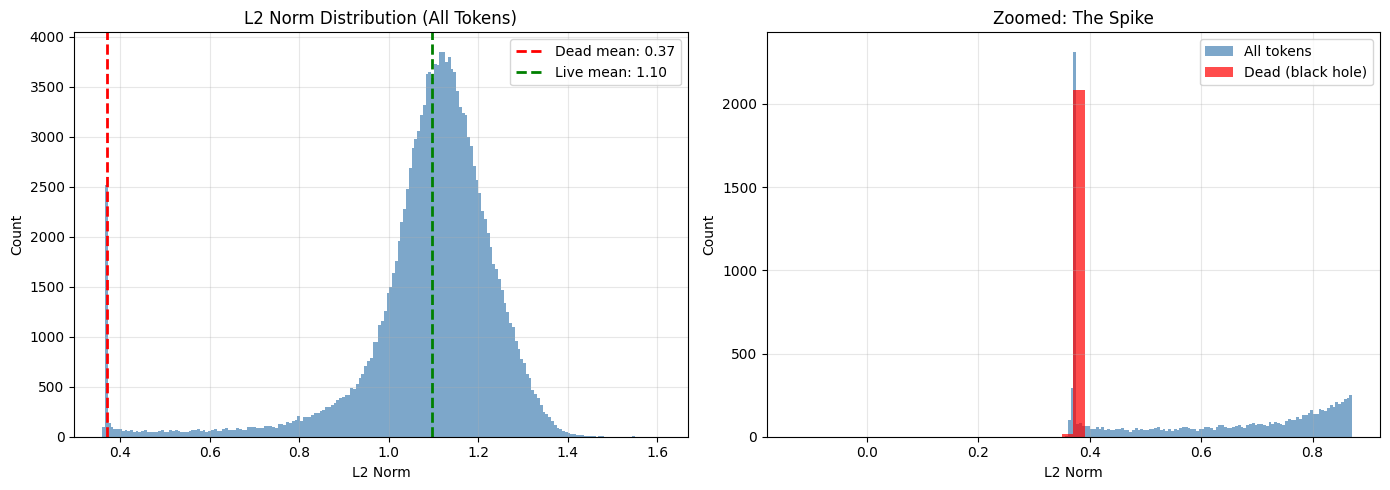

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: All tokens
ax = axes[0]
ax.hist(norms.numpy(), bins=200, color='steelblue', alpha=0.7, edgecolor='none')
ax.axvline(norms_dead.mean().item(), color='red', linestyle='--', linewidth=2, label=f'Dead mean: {norms_dead.mean():.2f}')
ax.axvline(norms_live.mean().item(), color='green', linestyle='--', linewidth=2, label=f'Live mean: {norms_live.mean():.2f}')
ax.set_xlabel('L2 Norm')
ax.set_ylabel('Count')
ax.set_title('L2 Norm Distribution (All Tokens)')
ax.legend()
ax.grid(alpha=0.3)

# Right: Zoom on the spike
ax = axes[1]
# Find the range where dead tokens live
dead_min, dead_max = norms_dead.min().item(), norms_dead.max().item()
margin = 0.5
ax.hist(norms.numpy(), bins=200, range=(dead_min - margin, dead_max + margin), 
        color='steelblue', alpha=0.7, edgecolor='none', label='All tokens')
ax.hist(norms_dead.numpy(), bins=50, range=(dead_min - margin, dead_max + margin),
        color='red', alpha=0.7, edgecolor='none', label='Dead (black hole)')
ax.set_xlabel('L2 Norm')
ax.set_ylabel('Count')
ax.set_title('Zoomed: The Spike')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('l2_norm_histogram@72.png', dpi=72)
plt.show()

## Where is the spike relative to the main distribution?

In [5]:
# What percentile are the dead tokens at?
dead_mean_norm = norms_dead.mean().item()
percentile = (norms < dead_mean_norm).float().mean().item() * 100

print(f"Dead token mean norm: {dead_mean_norm:.4f}")
print(f"This is at the {percentile:.1f}th percentile of all tokens.")
print()
print(f"In other words: {100-percentile:.1f}% of live tokens have LARGER norms than the dead token mean.")

Dead token mean norm: 0.3709
This is at the 1.0th percentile of all tokens.

In other words: 99.0% of live tokens have LARGER norms than the dead token mean.


In [6]:
# How much smaller are dead tokens?
ratio = norms_live.mean().item() / norms_dead.mean().item()
print(f"Live tokens are {ratio:.2f}x larger (in L2 norm) than dead tokens on average.")

Live tokens are 2.96x larger (in L2 norm) than dead tokens on average.


## The Spike in Detail

In [7]:
# How tight is the dead token distribution?
print(f"Dead token norm range: [{norms_dead.min():.6f}, {norms_dead.max():.6f}]")
print(f"Dead token norm spread: {norms_dead.max() - norms_dead.min():.6f}")
print(f"Dead token norm std: {norms_dead.std():.6f}")
print()
print(f"For comparison, live token std: {norms_live.std():.6f}")
print(f"Dead tokens are {norms_live.std() / norms_dead.std():.1f}x tighter than live tokens.")

Dead token norm range: [0.370916, 0.370918]
Dead token norm spread: 0.000002
Dead token norm std: 0.000000

For comparison, live token std: 0.146206
Dead tokens are 823780.2x tighter than live tokens.
